# Setup

In [1]:
# Python 3 compatability
from __future__ import division, print_function

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
import scipy
from scipy import stats

# plotting
import matplotlib
from matplotlib import pyplot as plt

# fits data
from astropy.io import fits

# inline plotting
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Star with Fixed Background

Load and process data.

In [3]:
# number of runs
nruns, ntrials = 9, 100000

# clip outliers where optimization might have failed
sigclip = 5.

# true values
f, ferr, ftrials = np.zeros((3, nruns))

# extract data
flux, fluxerr, x, y = np.zeros((4, nruns, ntrials))
for i in range(nruns):
    fname = 'data/fix_back/run{0}.fits'.format(i)  # run
    if os.path.isfile(fname):
        hdul = fits.open(fname)
        # grab true values
        f[i] = hdul[0].header['TRUEFLUX']  # true flux
        psfwidth = hdul[0].header['PSFWIDTH']  # Gaussian PSF width
        noise = hdul[0].header['NOISE']  # iid Gaussian noise
        aeff = 4. * np.pi * psfwidth**2  # effective area
        ferr[i] = np.sqrt(aeff * noise**2)  # true error
        # grab trials
        data = hdul[1].data
        flux[i] = data['Flux']  # fluxes
        fluxerr[i] = data['Fluxerr']  # flux errors
        x[i], y[i] = data['X'], data['Y']  # positions
        # clip suspicious trials
        pos = np.c_[x[i], y[i]]
        cinv = np.linalg.inv(np.cov(pos, rowvar=False))  # inv-cov
        sqdist = np.array([np.dot(np.dot(p, cinv), p) 
                           for p in pos])  # normalized distance
        sel = (sqdist <= sigclip**2) & (flux[i] / fluxerr[i] > 0.2)  # clip outliers
        flux[i, ~sel], fluxerr[i, ~sel] = np.nan, np.nan
        x[i, ~sel], y[i, ~sel] = np.nan, np.nan
        ftrials[i] = len(sel)
    else:
        print(fname + ' not found.')  # some runs failed because of bad optimizing

In [4]:
# define relevant quantities

snr = f / ferr  # true SNR
favg, fstd = np.nanmean(flux, axis=1), np.nanstd(flux, axis=1)
fbias_avg = (favg - f) / f  # fractional bias
fbias_err = fstd / f / np.sqrt(ftrials)  # uncertainty

flux_snr = flux / fluxerr  # measured SNR
flux_debias = flux * (1 - flux_snr**-2 - flux_snr**-4)  # de-biased flux
fdebias_avg = np.nanmean(flux_debias, axis=1)  # average
fdebias_std = np.nanstd(flux_debias, axis=1)  # scatter

# derive error via bootstrapping
np.random.seed(16196)  # declare seed
nbootstrap = 250
fdebias_std_err = np.array([np.nanstd([np.nanstd(np.random.choice(flux_debias[j], 
                                                                  size=ntrials)) 
                                       for i in range(nbootstrap)])
                            for j in range(nruns)])  # error on scatter

Plot bias as a function of SNR.

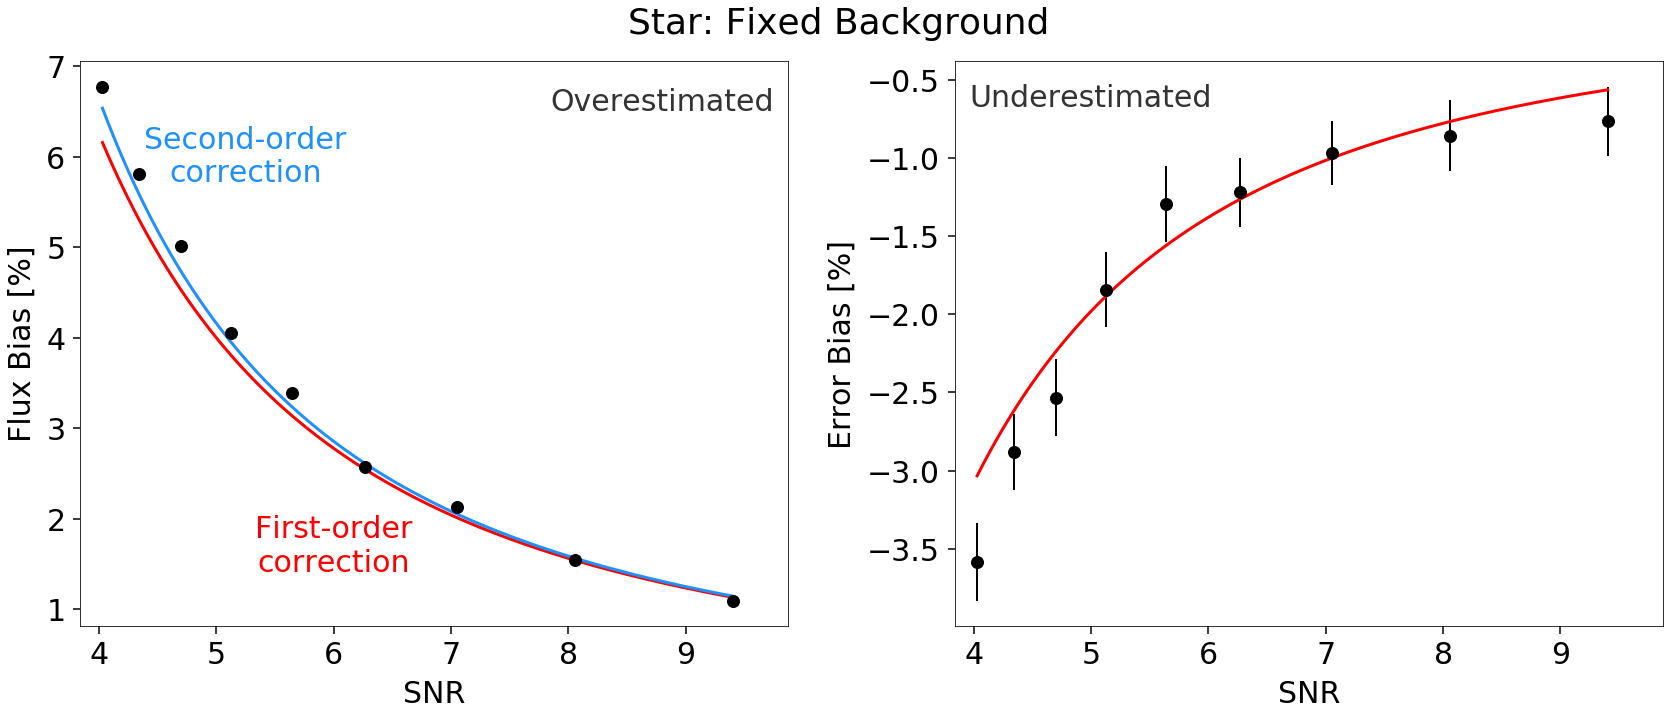

In [5]:
snr_grid = np.linspace(np.nanmin(snr), np.nanmax(snr), 1000)

# plot flux bias + variance
plt.figure(figsize=(24, 10))
plt.suptitle('Star: Fixed Background', y=1.02)

# flux
plt.subplot(1, 2, 1)
plt.errorbar(snr, fbias_avg * 100., yerr=fbias_err, marker='o', 
             color='black', linestyle='none', markersize=12,
             elinewidth=2)  # avg fractional bias
plt.plot(snr_grid, snr_grid**-2 * 100.,
         linestyle='-', color='red',
         label='1st-order', lw=3)  # 1st-order correction
plt.plot(snr_grid, (snr_grid**-2 + snr_grid**-4) * 100.,
         linestyle='-', color='dodgerblue',
         label='2nd-order', lw=3)  # 2nd-order correction
# label lines
plt.text(6, 1.7, 'First-order\ncorrection', 
         horizontalalignment='center', verticalalignment='center',
         color='red')
plt.text(5.25, 6, 'Second-order\ncorrection', 
         horizontalalignment='center', verticalalignment='center',
         color='dodgerblue')
# prettify
plt.text(8.8, 6.6, 'Overestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.xlabel(r'SNR', labelpad=10)
plt.ylabel(r'Flux Bias [%]', labelpad=10)
plt.xlim(np.min(snr) / 1.05, np.max(snr) * 1.05)
plt.tight_layout()

# errors
plt.subplot(1, 2, 2)
plt.errorbar(snr, (1. - fdebias_std / ferr) * 100.,
             yerr=(fdebias_std_err / ferr) * 100.,
             marker='o', color='black', linestyle='none',
             markersize=12, elinewidth=2)  # avg fractional error bias
plt.plot(snr_grid, (1. - np.sqrt(1 + snr_grid**-2)) * 100.,
         linestyle='-', color='red', 
         label='1st-order', lw=3)  # 1st-order correction
# prettify
plt.text(5.0, -0.62, 'Underestimated',
         horizontalalignment='center', verticalalignment='center',
         color='black', alpha=0.8)
plt.xlabel(r'SNR', labelpad=10)
plt.ylabel(r'Error Bias [%]', labelpad=10)
plt.xlim(np.min(snr) / 1.05, np.max(snr) * 1.05)
plt.tight_layout()

# save figure
plt.savefig('plots/star_fix_back.png', bbox_inches='tight')

Plot bias as a function of position.

/home/joshspeagle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


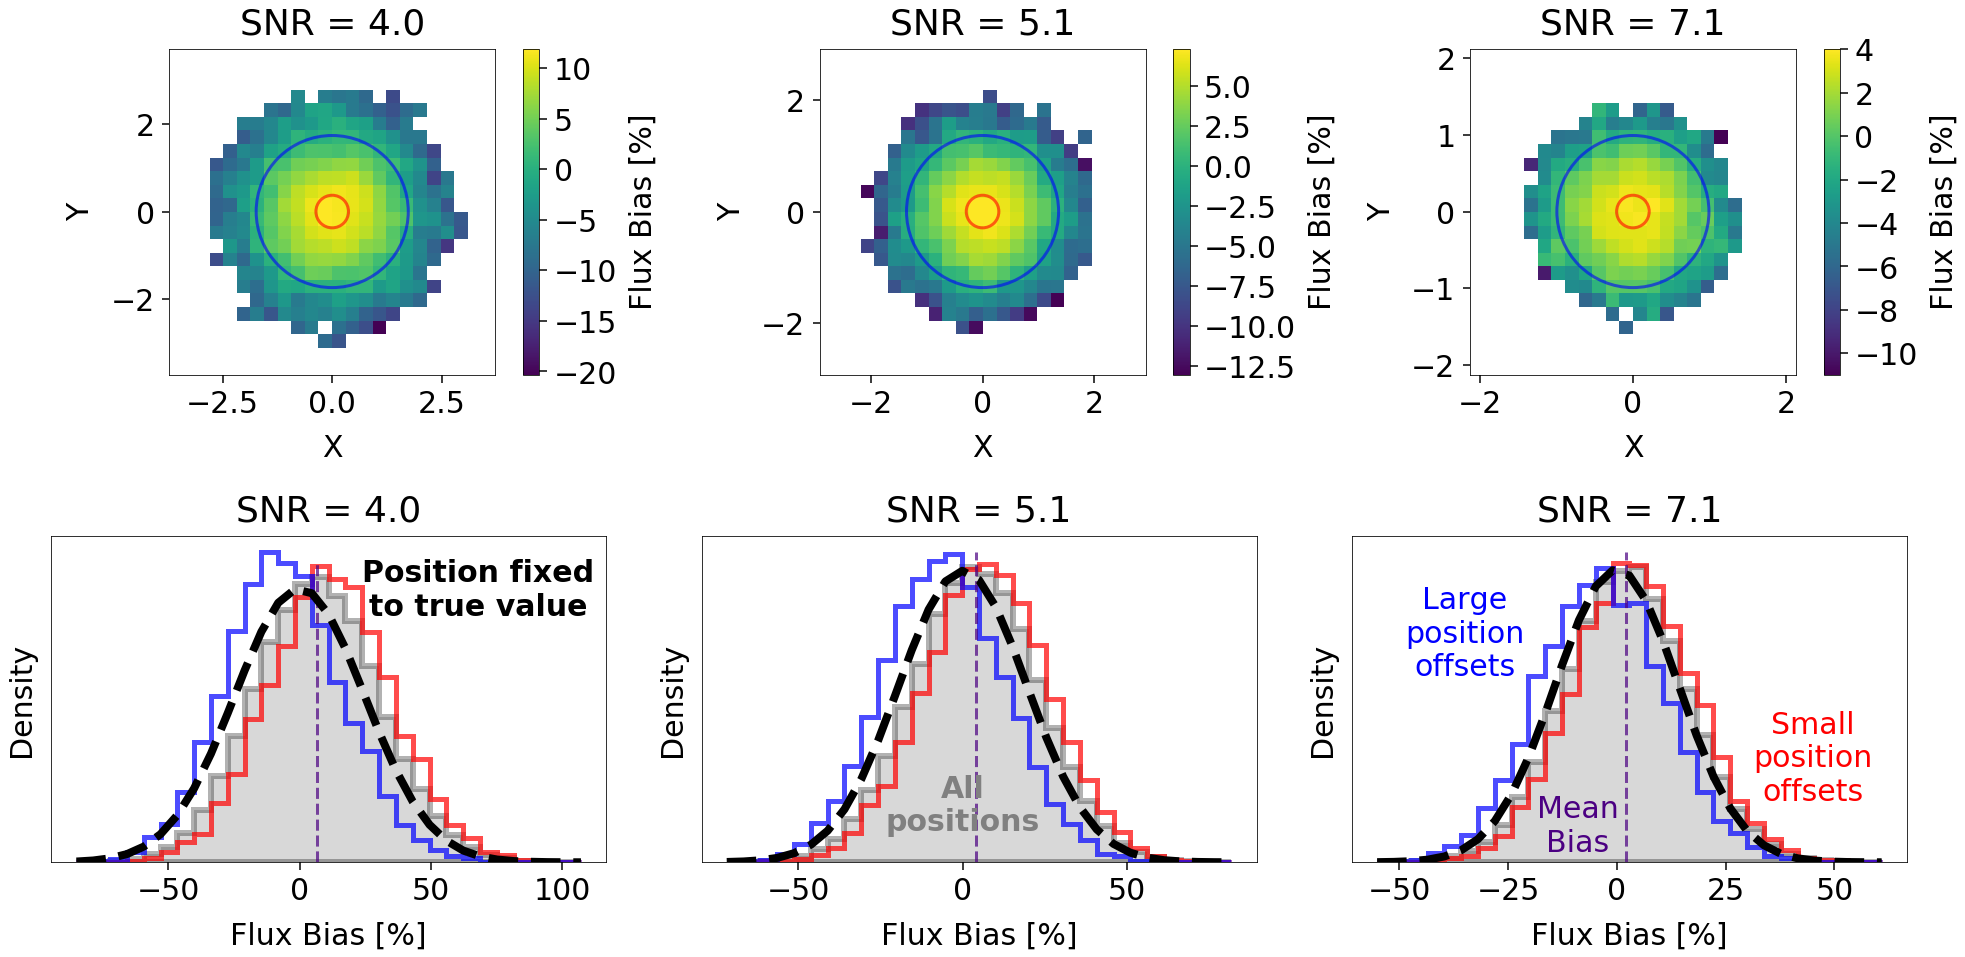

In [6]:
# ML flux bias as a function of position
idxs = [-1, -4, -7]

# avoid bad values
good = np.isfinite(x) & np.isfinite(y) & np.isfinite(flux)  # mask
nmin = 15  # minimum number of counts
smooth = 0.5  # smoothing scale

# plot results
from scipy.ndimage.filters import gaussian_filter
plt.figure(figsize=(28, 14))
for counter, i in enumerate(idxs):
    plt.subplot(2, 3, counter + 1)
    X, Y, Fb = x[i][good[i]], y[i][good[i]], (flux[i] / f[i])[good[i]]
    pos_grid = np.linspace(-2.5, 2.5, 25) / snr[i] * 6.  # generate (x,y) grid
    counts, _, _ = np.histogram2d(X, Y, bins=pos_grid)  # bin results
    fbias_stack, _, _  = np.histogram2d(X, Y, weights=Fb,
                                        bins=pos_grid)  # stack results
    fbias_stack_avg = (gaussian_filter(fbias_stack, smooth) / 
                       gaussian_filter(counts, smooth))  # average w/ gaussian smoothing
    fbias_stack_avg[counts < nmin] = np.nan  # mask bins with < nmin counts
    # 2-D plot
    extent=[pos_grid.min(), pos_grid.max(), pos_grid.min(), pos_grid.max()]
    plt.imshow(100. * (fbias_stack_avg - 1.), extent=extent)
    # prettify
    plt.xlabel('X')
    plt.ylabel('Y')
    cb = plt.colorbar()
    cb.set_label(label='Flux Bias [%]', labelpad=12)
    plt.title(r'SNR = {0}'.format(round(snr[i], 1)))
    plt.tight_layout()
    
    # flux distribution as a function of radius
    rin, rout = 1.5 / snr[i], 7. / snr[i]
    plt.gcf().gca().add_artist(plt.Circle((0., 0.), rin, color='red', 
                                          alpha=0.6, lw=3, fill=False))
    plt.gcf().gca().add_artist(plt.Circle((0., 0.), rout, color='blue', 
                                          alpha=0.6, lw=3, fill=False))
    plt.subplot(2, 3, counter + 4)
    n, b, _ = plt.hist((Fb - 1) * 100, 30, density=True, 
                       histtype='stepfilled', edgecolor='black', 
                       lw=6, color='gray', alpha=0.3);
    plt.vlines(np.mean((Fb - 1) * 100), 0, max(n) * 1.05, color='indigo', 
               lw=3, alpha=0.7, linestyle='dashed')
    plt.plot(b, stats.norm.pdf(f[i] * (b / 100 + 1), loc=f[i], scale=ferr[i]) * f[i] / 100, 
             lw=8, color='black', linestyle='dashed')
    sel = np.sqrt(X**2 + Y**2) < rin
    plt.hist((Fb[sel] - 1) * 100, b, density=True,
             histtype='step', lw=5, color='red', alpha=0.7);
    sel = np.sqrt(X**2 + Y**2) > rout
    plt.hist((Fb[sel] - 1) * 100, b, density=True,
             histtype='step', lw=5, color='blue', alpha=0.7);
    # prettify
    plt.xlabel('Flux Bias [%]')
    plt.ylabel('Density')
    plt.yticks([])
    plt.title(r'SNR = {0}'.format(round(snr[i], 1)))
    plt.tight_layout()
    # add labels
    if counter == 0:
        plt.text(68, 16e-3, 'Position fixed\nto true value', 
                 horizontalalignment='center', verticalalignment='center',
                 color='black', weight='heavy') 
    if counter == 1:
        plt.text(0, 4e-3, 'All\npositions', 
                 horizontalalignment='center', verticalalignment='center',
                 color='gray', weight='heavy')
    if counter == 2:
        plt.text(45, 10e-3, 'Small\nposition\noffsets', 
                 horizontalalignment='center', verticalalignment='center',
                 color='red')
        plt.text(-35, 22e-3, 'Large\nposition\noffsets', 
                 horizontalalignment='center', verticalalignment='center',
                 color='blue')
        plt.text(-9, 3.5e-3, 'Mean\nBias', 
                 horizontalalignment='center', verticalalignment='center',
                 color='indigo')
    
# save figure
plt.savefig('plots/star_fix_back_pos.png', bbox_inches='tight')